In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from IPython.display import HTML

In [3]:
params = {'font.size':12, 'legend.fontsize':'medium', 'axes.labelsize':'large', 'axes.titlesize':'large'}
plt.rcParams.update(params)

In [4]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
# Valentina Guarino, mat. 978477

## <span style="color:red">  ESERCITAZIONE 10</span>

### Ottimizzazione del TSP: SA e parallel GA

Viene esplorato nuovamente il problema del commesso viaggiatore, cercando di ottimizzare il problema in due casi diversi: con un algoritmo di Simulated Annealing e con un un Algoritmo Genetico svolto però tramite calcolo parallelo.

#### Travel Salesman Problem

Il problema consiste in un commesso viaggiatore che deve visitare un certo numero _n_ di città distribuite in modo random. L'ottimizzazione del problema consiste nel trovare la strada più corta che può essere percorsa soddisfando alcuni vincoli:
- Ogni città dev'essere visitata una sola volta
- La città di arrivo finale dev'essere la stessa città di partenza

Se $\vec{x} = {1,...,n}$ sono le diverse città da visitare, la distanza minima percorsa in totale si trova calcolando una funzione di costo 
$L(\vec{x}) = \sum_{i = 1}^n d(x_i, x_{i+1})$ da minimizzare, dove $d(x_i, x_{i+1})$ è la distanza tra due città $x_i, x_{i+1}$. Per questo tipo di problema di ottimizzazione la funzione di costo $L(\vec{x})$ possiede molti minimi locali.

Il problema è un problema di ottimizzazione di tipo combinatorio: esiste un numero finito di possibili percorsi unici, e  per un numero di città $n \geq 3$ esso equivale a $\frac{(n-1)!}{2}$.

#### Simulated Annealing

L'algoritmo di SA si basa concettualmente su un modello di meccanica statistica, in particolare sul raffreddamento e la cristallizzazione dei liquidi. Mentre un liquido ad alte $T$ permette ai suoi atomi di muoversi liberamente, se si diminuisce in modo graduale la temperatura il liquido inizierà a cristallizzarsi grazie all'allineamento progressivo degli atomi. Lo stato di cristallo a bassa temperatura equivale anche allo stato di minima energia del sistema.

Questo modello può essere trasposto in ambito di ottimizzazione numerica considerando la distribuzione di Boltzmann

$$p(x) = \frac{e^{-\beta L(x)}}{Z}$$

dove $Z$ è la funzione di partizione del sistema e la cost function $L(x)$ equivale all'energia che si avrebbe per un sistema termodinamico.

Il processo di SA consiste in una catena di Markov dipendente dal tempo: scelta una $T$ iniziale sufficientemente elevata, essa viene fatta decrescere gradualmente. Per ogni temperatura viene eseguito un campionamento di Metropolis generando una nuova configurazione $x'$, con associata una cost function $L(x')$, che viene sostituita alla configurazione precedente con una probabilità pari a

$$p(x) = e^{-\beta (L(x') - L(x))}, \quad L(x') > L(x)$$

La configurazione finale scelta tramite accettazione di Metropolis sarà utilizzata come configurazione iniziale per la temperatura successiva.
Il processo campiona dunque le varie configurazioni in base alla loro probabilità termodinamica; diminuendo la temperatura fino a valori prossimi allo zero, in modo da avere $\beta \rightarrow +\infty$, la distribuzione delle probabilità sarà concentrata sui valori minimi di $L(x)$ e pertanto la simulazione (se abbastanza lunga) riuscirà a raggiungere il minimo globale dell'"energia" del sistema, ovvero la cost function $L(x)$.

#### Genetic Search: parallel Genetic Algorithm

Il parallel computing consiste nel far girare un singolo codice su diversi processori in modo da diminuire il tempo di simulazione e lo spazio di memoria necessario. In una parallelizzazione di tipo Message Passing (MPP) ogni nodo comunica con gli altri durante l'esecuzione della parte parallelizzabile del codice: in un modello di tipo Single Program Multiple Data (SPMD) vi è un singolo programma che viene eseguito sui diversi nodi utilizzando diversi set di dati.

![SegmentLocal](SPMD.png "SPMD")

Nell'esercitazione svolta ogni nodo eseguiva un Genetic Search relativo al problema del commesso viaggiatore su un determinato $Continente$. Dopo un certo numero di generazioni, i nodi si scambiavano gli individui migliori trovati nei loro $Continenti$.

La parallelizzazione avviene grazie all'utilizzo della libreria $MPI$ (Message Passing Interface) contenuta nel C++

### Esercizio 10.1: Simulated Annealing

Viene modificato il codice dell'algoritmo genetico in modo da effettuare un simulated annealing. Si cerca il percorso minimo compiuto da un commesso viaggiatore nella visita di:
- 32 città poste su una circonferenza
- 32 città poste all'interno di un quadrato

Si parte da una temperatura iniziale $T=30$, e la si decrementa con uno scaling factor $\alpha$ come $T = \alpha T$. Per ogni temperatura vengono proposte, per un certo numero di volte, alcune mosse da effettuare sul percorso iniziale dato; queste mosse, che equivalgono agli operatori di *Mutazione* dell'algoritmo genetico, verranno accettate o meno in base all'esito di un algoritmo di Metropolis in cui il peso di Boltzmann è dato dalla funzione di costo 
$$p(x) = e^{-\beta (L(x') - L(x))}$$


Viene scelta la seguente annealing schedule: 
- Per $T \in [30, 2]$,  $\alpha = 0.5$
- Per $T \in [2, 0.005]$,  $\alpha = 0.9999$

La temperatura viene dunque diminuita più velocemente fintanto che è sufficientemente alta, mentre viene diminuita più lentamente per valori di $T < 2$, in modo da visitare accuratamente le configurazioni di minima energia del sistema che si trovano quando la temperatura assume valori piccoli (e $\beta = \frac{1}{T} \rightarrow \infty$) e riuscire a giungere al minimo globale del sistema.

In modo da poter effettuare un confronto con i risultati ottenuti nell'*Esercitazione 9*, il codice viene modificato in modo da prendere come percorso iniziale lo stesso da cui si è partiti con l'algoritmo genetico. Si ottengono i seguenti risultati:

#### Città poste su una circonferenza

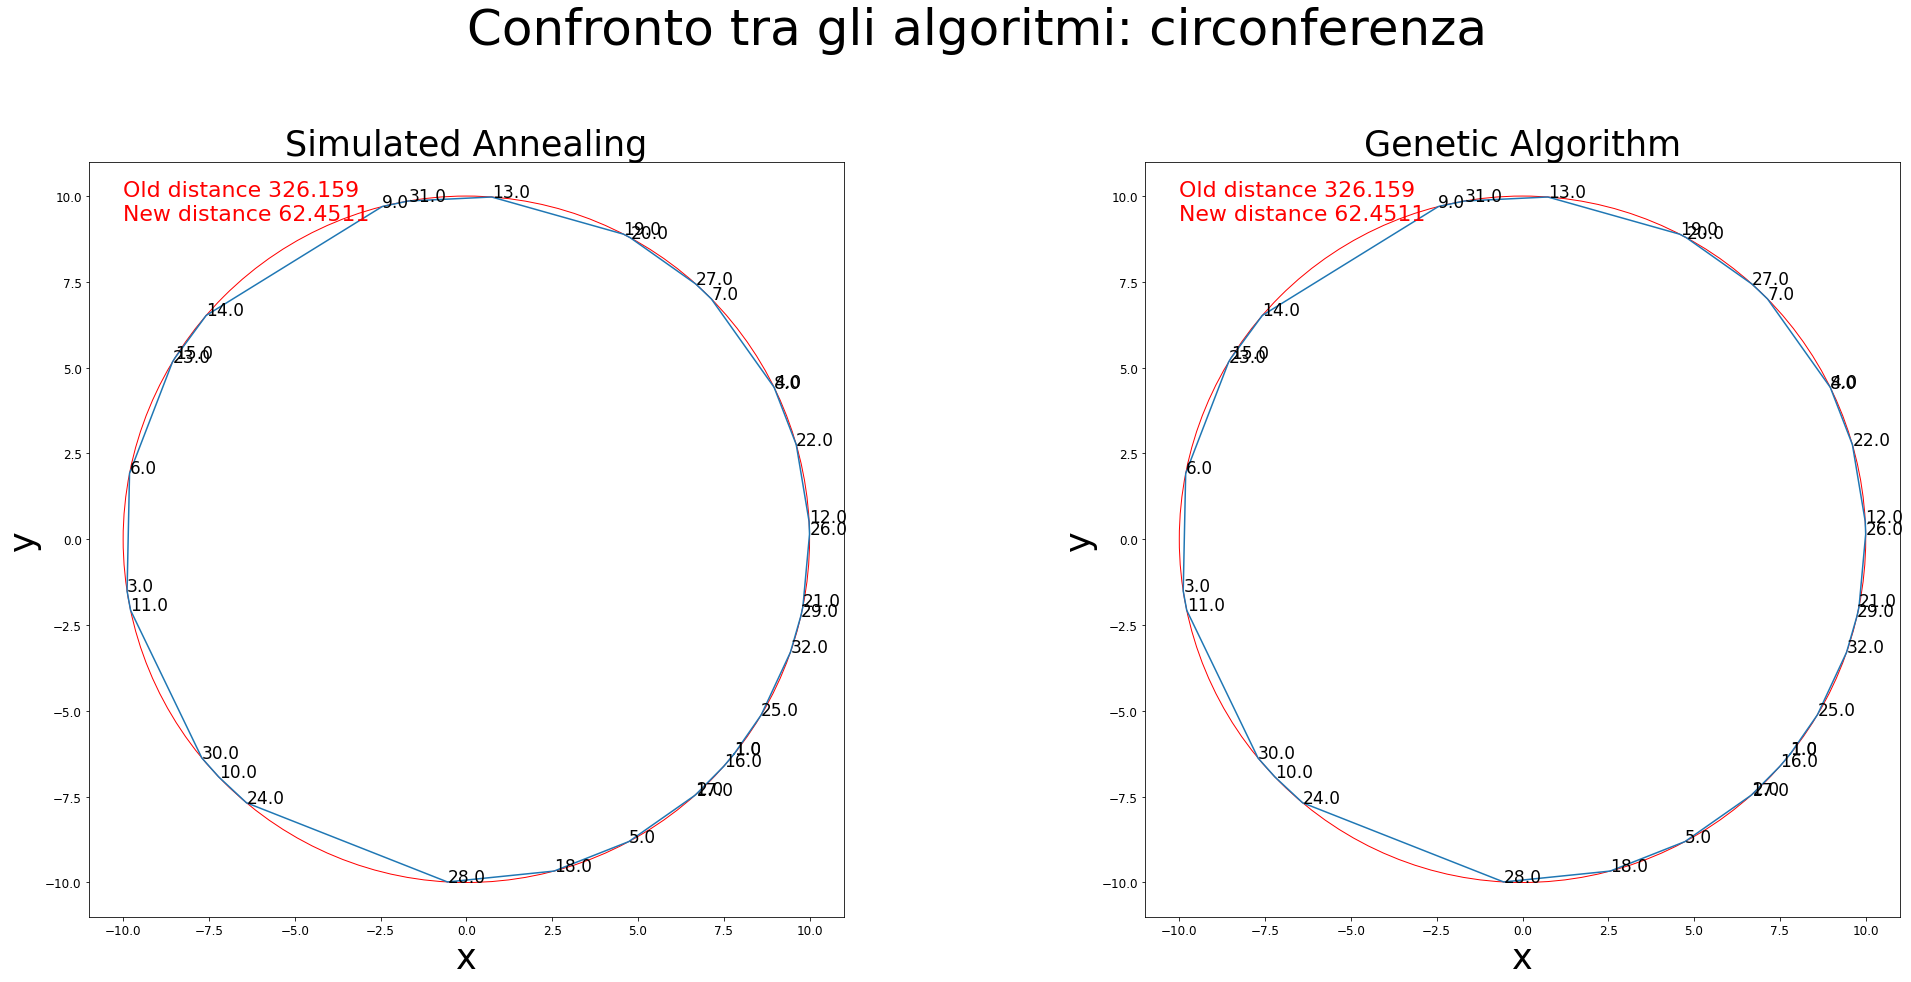

In [13]:
plt.figure(figsize=(30,27))

plt.subplot(2,2,1)
coord_x, coord_y, name, dist, old_dist = np.loadtxt("bestpath.dat", usecols = (0, 1, 2, 3, 4), delimiter = ' ', unpack = 'True')
circle = plt.Circle((0,0), 10.0, ec = "red", fill = False)
plt.gca().add_patch(circle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)
    
#plt.legend(loc="center left", bbox_to_anchor=(0.73, 1.), fontsize = 20)

plt.xlabel("x", fontsize = 35)
plt.ylabel("y", fontsize = 35)
plt.annotate("Old distance {}".format(old_dist[0]), (-10.0,10.0), fontsize = 22, color = "red")
plt.annotate("New distance {}".format(dist[0]), (-10.0, 9.3), fontsize = 22, color = "red")
plt.title("Simulated Annealing", fontsize = 35)

plt.subplot(2,2,2)
coord_x, coord_y, name, dist, old_dist = np.loadtxt("GA/bestpath.dat", usecols = (0, 1, 2, 3, 4), delimiter = ' ', unpack = 'True')
circle = plt.Circle((0,0), 10.0, ec = "red", fill = False)
plt.gca().add_patch(circle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)
    
#plt.legend(loc="center left", bbox_to_anchor=(0.75, 1.), fontsize = 20)

plt.xlabel("x", fontsize = 35)
plt.ylabel("y", fontsize = 35)
plt.annotate("Old distance {}".format(old_dist[0]), (-10.0,10.0), fontsize = 22, color = "red")
plt.annotate("New distance {}".format(dist[0]), (-10.0, 9.3), fontsize = 22, color = "red")
plt.title("Genetic Algorithm", fontsize = 35)

plt.suptitle("Confronto tra gli algoritmi: circonferenza", fontsize = 50)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()


Viene anche mostrata la variazione della norma $L_1$ al variare delle iterazioni dell'algoritmo, mostrando i valori ogni $1000$ iterazioni

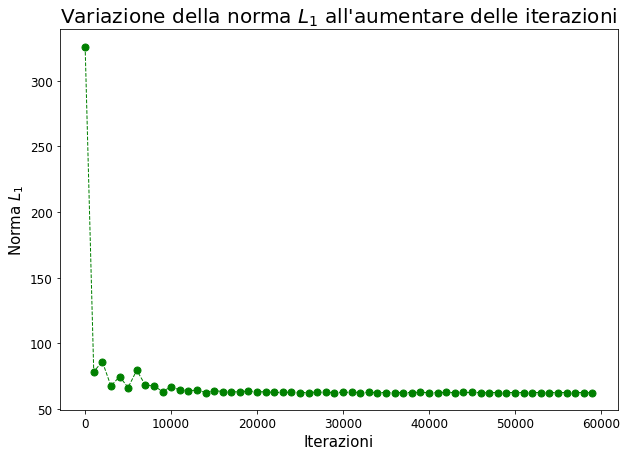

In [18]:
plt.figure(figsize=(10,7))
gen, L1 = np.loadtxt("L1.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "g", markersize = 7., linewidth = 1.)

plt.xlabel("Iterazioni", fontsize = 15)
plt.ylabel("Norma $L_1$", fontsize = 15)
plt.title("Variazione della norma $L_1$ all'aumentare delle iterazioni", fontsize = 20)
plt.show()

#### Città poste in un quadrato

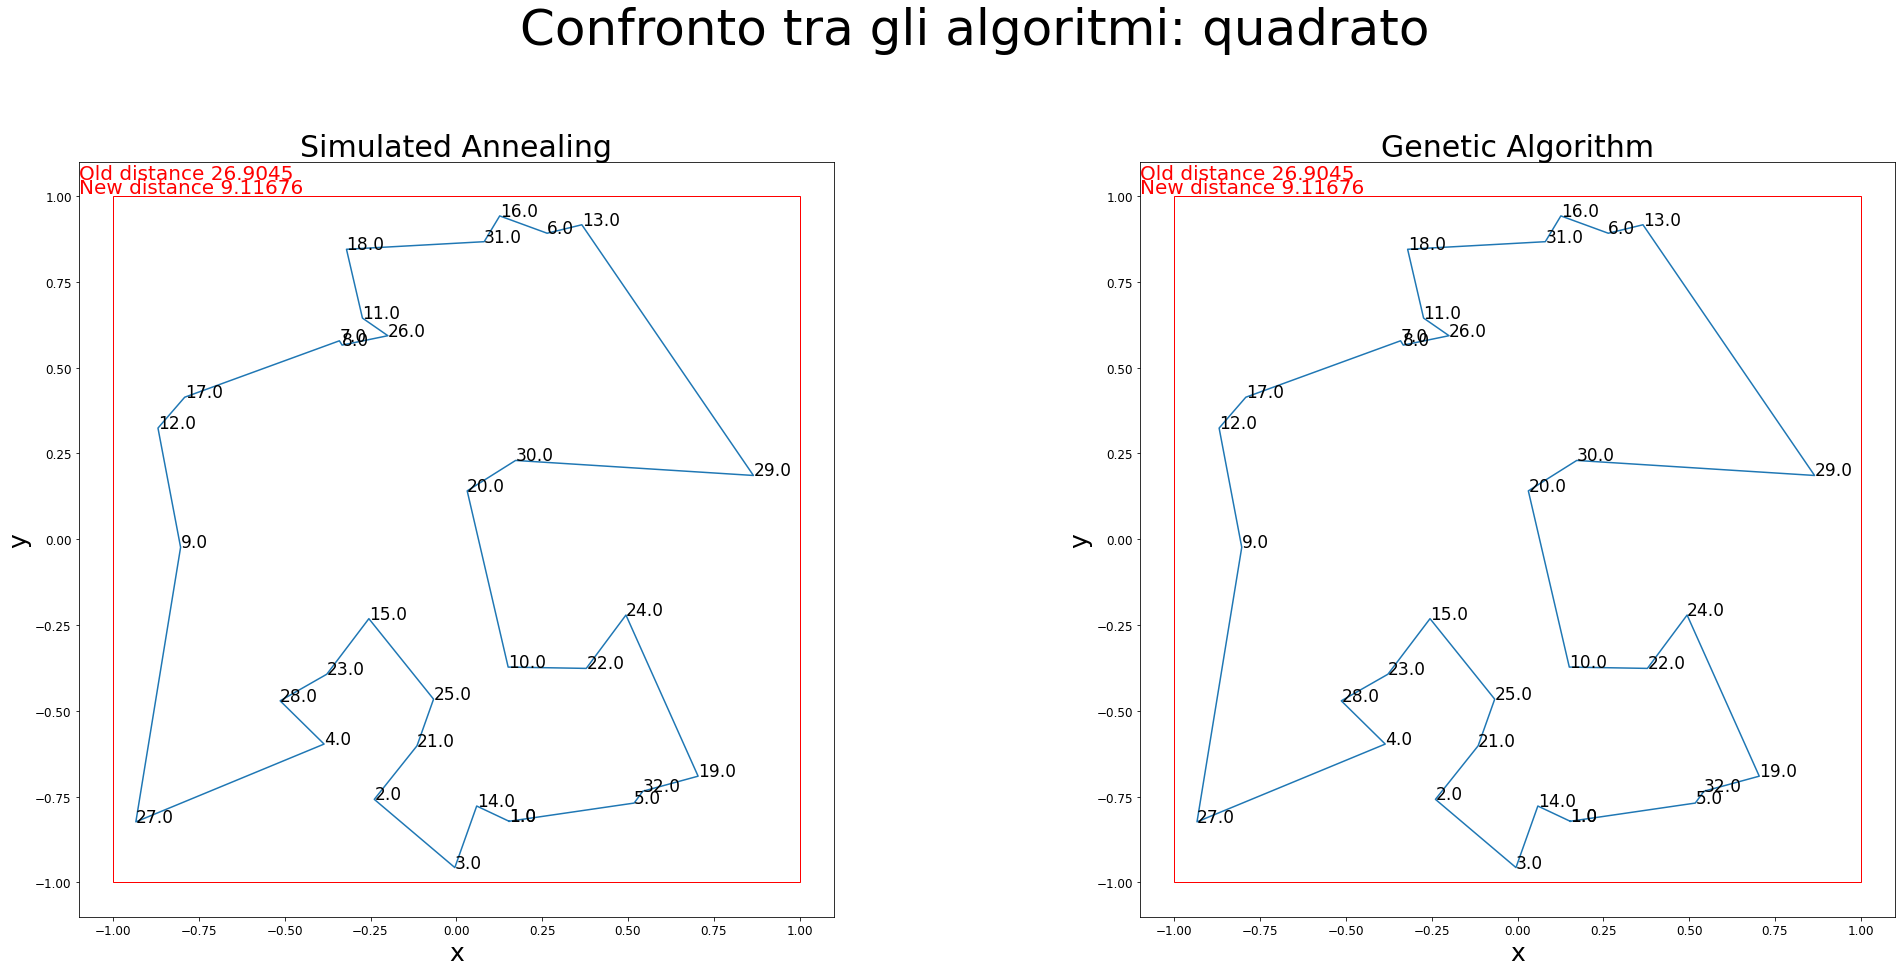

In [17]:
plt.figure(figsize=(30,27))

plt.subplot(2,2,1)
coord_x, coord_y, name, dist, old_dist = np.loadtxt("bestpath_square.dat", usecols = (0, 1, 2, 3, 4), delimiter = ' ', unpack = 'True')
rectangle = plt.Rectangle((-1.,-1.), 2, 2, ec="red", fill = False)
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)

#plt.legend(loc="center left", bbox_to_anchor=(1, 0.95), fontsize = 20)

plt.xlabel("x", fontsize = 25)
plt.ylabel("y", fontsize = 25)
plt.annotate("Old distance {}".format(old_dist[0]), (-1.1,1.05), fontsize = 20, color = "red")
plt.annotate("New distance {}".format(dist[0]), (-1.1, 1.009), fontsize = 20, color = "red")
plt.title("Simulated Annealing", fontsize = 30)

plt.subplot(2,2,2)
coord_x, coord_y, name, dist, old_dist = np.loadtxt("GA/bestpath_square.dat", usecols = (0, 1, 2, 3, 4), delimiter = ' ', unpack = 'True')
rectangle = plt.Rectangle((-1.,-1.), 2, 2, ec="red", fill = False)
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)

#plt.legend(loc="center left", bbox_to_anchor=(1, 0.95), fontsize = 20)

plt.xlabel("x", fontsize = 25)
plt.ylabel("y", fontsize = 25)
plt.annotate("Old distance {}".format(old_dist[0]), (-1.1,1.05), fontsize = 20, color = "red")
plt.annotate("New distance {}".format(dist[0]), (-1.1, 1.009), fontsize = 20, color = "red")
plt.title("Genetic Algorithm", fontsize = 30)

plt.suptitle("Confronto tra gli algoritmi: quadrato", fontsize = 50)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()


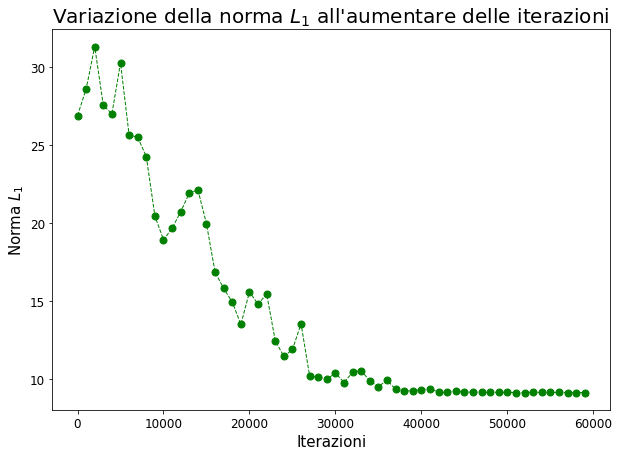

In [19]:
plt.figure(figsize=(10,7))
gen, L1 = np.loadtxt("L1_square.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "g", markersize = 7., linewidth = 1.)

plt.xlabel("Iterazioni", fontsize = 15)
plt.ylabel("Norma $L_1$", fontsize = 15)
plt.title("Variazione della norma $L_1$ all'aumentare delle iterazioni", fontsize = 20)
plt.show()

#### Considerazioni

Dal confronto si evince come entrambi gli algoritmi riescano a minimizzare correttamente il sistema, giungendo in una situazione di minimo globale. Nel caso del simulated annealing vengono compiute in totale circa $59000$ iterazioni: dal grafico dell'andamento della norma $L_1$ si può notare come, nel caso di città poste su circonferenza, siano sufficienti circa $10000$ iterazioni per arrivare a configurazioni di minimo globale, mentre nel caso di città poste in un quadrato il numero di iterazioni sufficienti salga a più di $40000$. Computazionalmente l'algoritmo di Simulated Annealing risulta più lento rispetto al Genetic Algorithm: ciò è dovuto al fatto che, mentre nel GA si ha una popolazione di $100$ possibili percorsi su cui vengono effettuate le diverse operazioni genetiche, nel SA si ha un singolo percorso iniziale a cui vengono applicate le mosse tentativo; è richiesto dunque più tempo affinché si riesca a trovare il percorso ottimale. Inoltre, data la richiesta del SA di diminuire la temperatura in modo graduale, è necessario un numero di iterazioni elevato per raggiungere una temperatura sufficientemente bassa da trovare il minimo globale del sistema, senza rischiare di incastrarsi in suoi minimi locali. 

In generale per città poste su una circonferenza è preferibile utilizzare un GA in quanto, a parità di risultato, il tempo computazionale utilizzato per simulare $250$ generazioni è nettamente inferiore rispetto a quello utilizzato dal SA per le sue $59000$ iterazioni.

Per il caso di città poste in un quadrato, invece, si è visto come un GA necessitasse di $800$ generazioni per riuscire a trovare il minimo globale; esso, inoltre, non veniva raggiunto in tutte le simulazioni effettuate in quanto in alcune di esse il minimo trovato era un minimo locale di valore leggermente superiore a quello globale. Pertanto per quest'ultimo caso sembra essere preferibile un SA che, nonostante un tempo di simulazione maggiore, ci assicura di trovare sempre il valore del minimo globale del percorso.

### Esercizio 10.02: Parallel Genetic Search

Viene parallelizzato il codice dell'algoritmo genetico, per città poste dentro un quadrato, lungo $4$ nodi del processore. Ogni nodo effettua una ricerca indipendente del percorso migliore, ovvero quello che minimizzi la distanza percorsa. Ogni $50$ generazioni due coppie di nodi, scelti in modo random, si scambiano il miglior individuo della popolazione. 

La simulazione viene effettuata lungo $800$ generazioni e produce per ogni nodo lo stesso percorso minimo, impiegando un tempo:
- Node $0$: $7.09129$ s
- Node $1$: $7.07944$ s
- Node $2$: $7.08902$ s
- Node $3$: $7.08699$ s


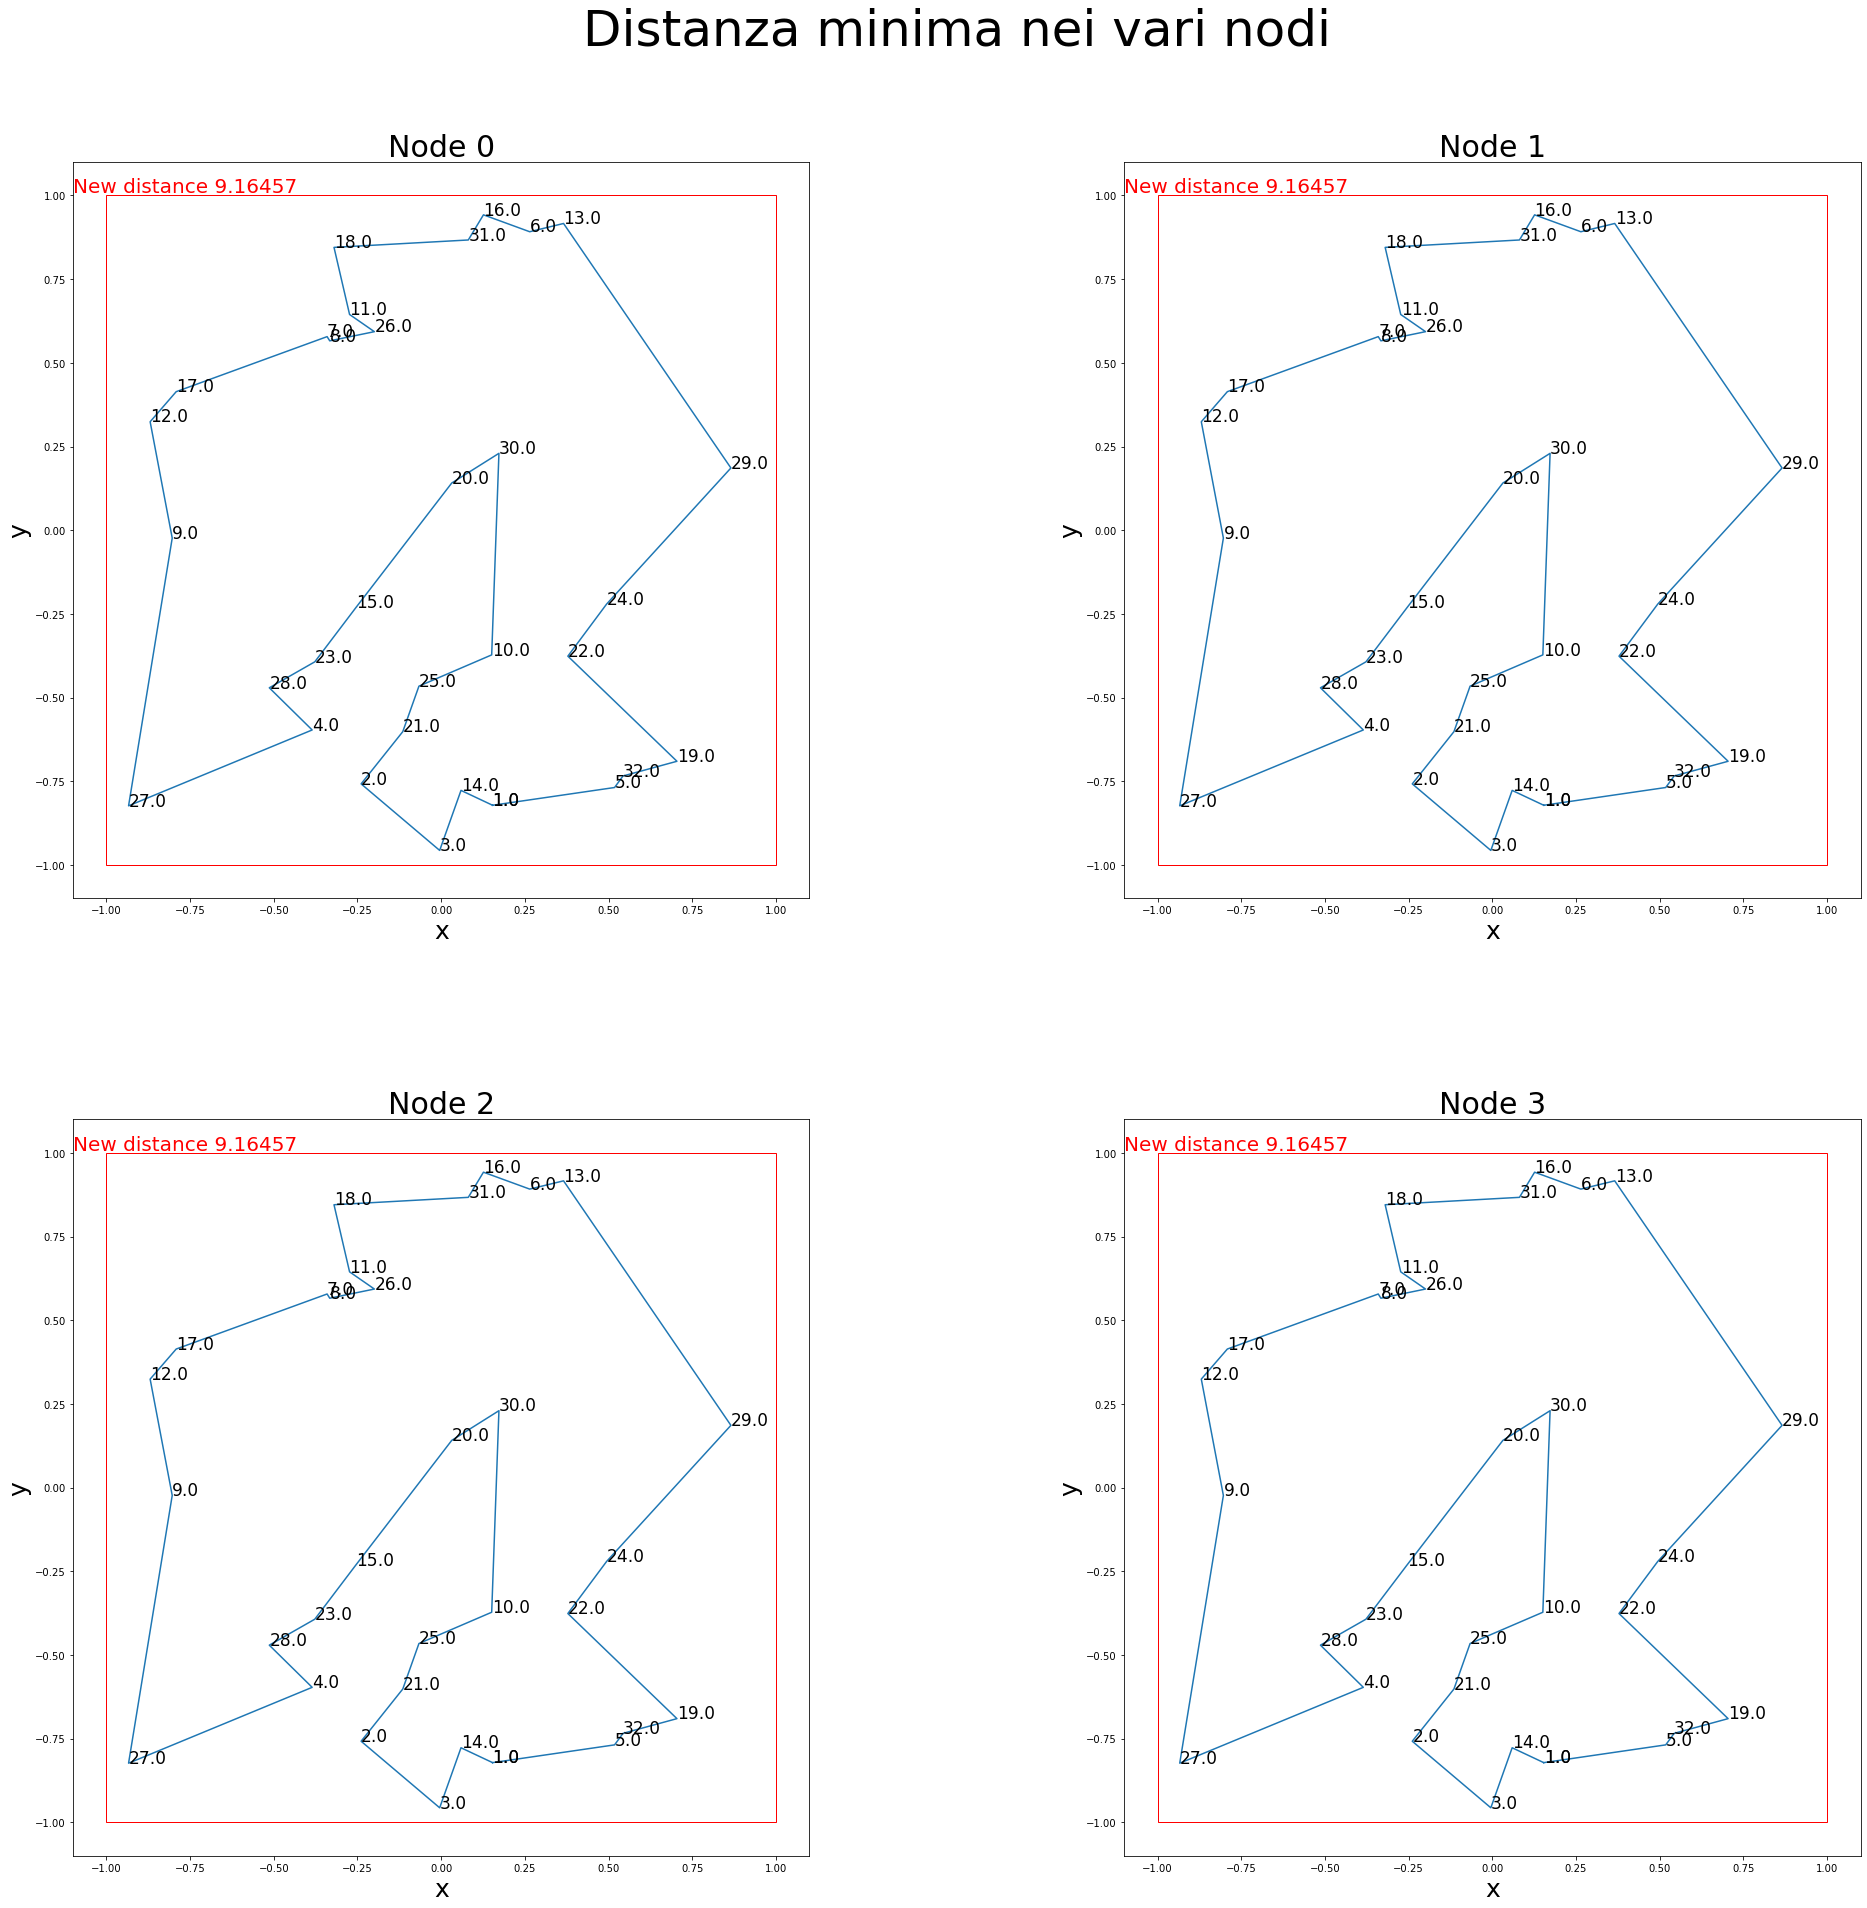

In [6]:
plt.figure(figsize=(30,27))

plt.subplot(2,2,1)
coord_x, coord_y, name, dist = np.loadtxt("10.2/bestpath_node0.dat", usecols = (0, 1, 2, 3), delimiter = ' ', unpack = 'True')
rectangle = plt.Rectangle((-1.,-1.), 2, 2, ec="red", fill = False)
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)

#plt.legend(loc="center left", bbox_to_anchor=(1, 0.95), fontsize = 20)

plt.xlabel("x", fontsize = 25)
plt.ylabel("y", fontsize = 25)
plt.annotate("New distance {}".format(dist[0]), (-1.1, 1.009), fontsize = 20, color = "red")
plt.title("Node 0", fontsize = 30)

plt.subplot(2,2,2)
coord_x, coord_y, name, dist = np.loadtxt("10.2/bestpath_node0.dat", usecols = (0, 1, 2, 3), delimiter = ' ', unpack = 'True')
rectangle = plt.Rectangle((-1.,-1.), 2, 2, ec="red", fill = False)
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)

#plt.legend(loc="center left", bbox_to_anchor=(1, 0.95), fontsize = 20)

plt.xlabel("x", fontsize = 25)
plt.ylabel("y", fontsize = 25)
plt.annotate("New distance {}".format(dist[0]), (-1.1, 1.009), fontsize = 20, color = "red")
plt.title("Node 1", fontsize = 30)

plt.subplot(2,2,3)
coord_x, coord_y, name, dist = np.loadtxt("10.2/bestpath_node0.dat", usecols = (0, 1, 2, 3), delimiter = ' ', unpack = 'True')
rectangle = plt.Rectangle((-1.,-1.), 2, 2, ec="red", fill = False)
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)

#plt.legend(loc="center left", bbox_to_anchor=(1, 0.95), fontsize = 20)

plt.xlabel("x", fontsize = 25)
plt.ylabel("y", fontsize = 25)
plt.annotate("New distance {}".format(dist[0]), (-1.1, 1.009), fontsize = 20, color = "red")
plt.title("Node 2", fontsize = 30)

plt.subplot(2,2,4)
coord_x, coord_y, name, dist = np.loadtxt("10.2/bestpath_node0.dat", usecols = (0, 1, 2, 3), delimiter = ' ', unpack = 'True')
rectangle = plt.Rectangle((-1.,-1.), 2, 2, ec="red", fill = False)
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.plot(coord_x, coord_y, label="Best path {}".format(name))
for i, txt in enumerate(name):
    plt.annotate(txt, (coord_x[i], coord_y[i]), fontsize = 17)

#plt.legend(loc="center left", bbox_to_anchor=(1, 0.95), fontsize = 20)

plt.xlabel("x", fontsize = 25)
plt.ylabel("y", fontsize = 25)
plt.annotate("New distance {}".format(dist[0]), (-1.1, 1.009), fontsize = 20, color = "red")
plt.title("Node 3", fontsize = 30)

plt.suptitle("Distanza minima nei vari nodi", fontsize = 50)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()


Viene calcolata anche la variazione della norma $L_1$ al variare delle generazioni e la media $<L_1>$ sulla metà migliore della popolazione per ogni nodo:

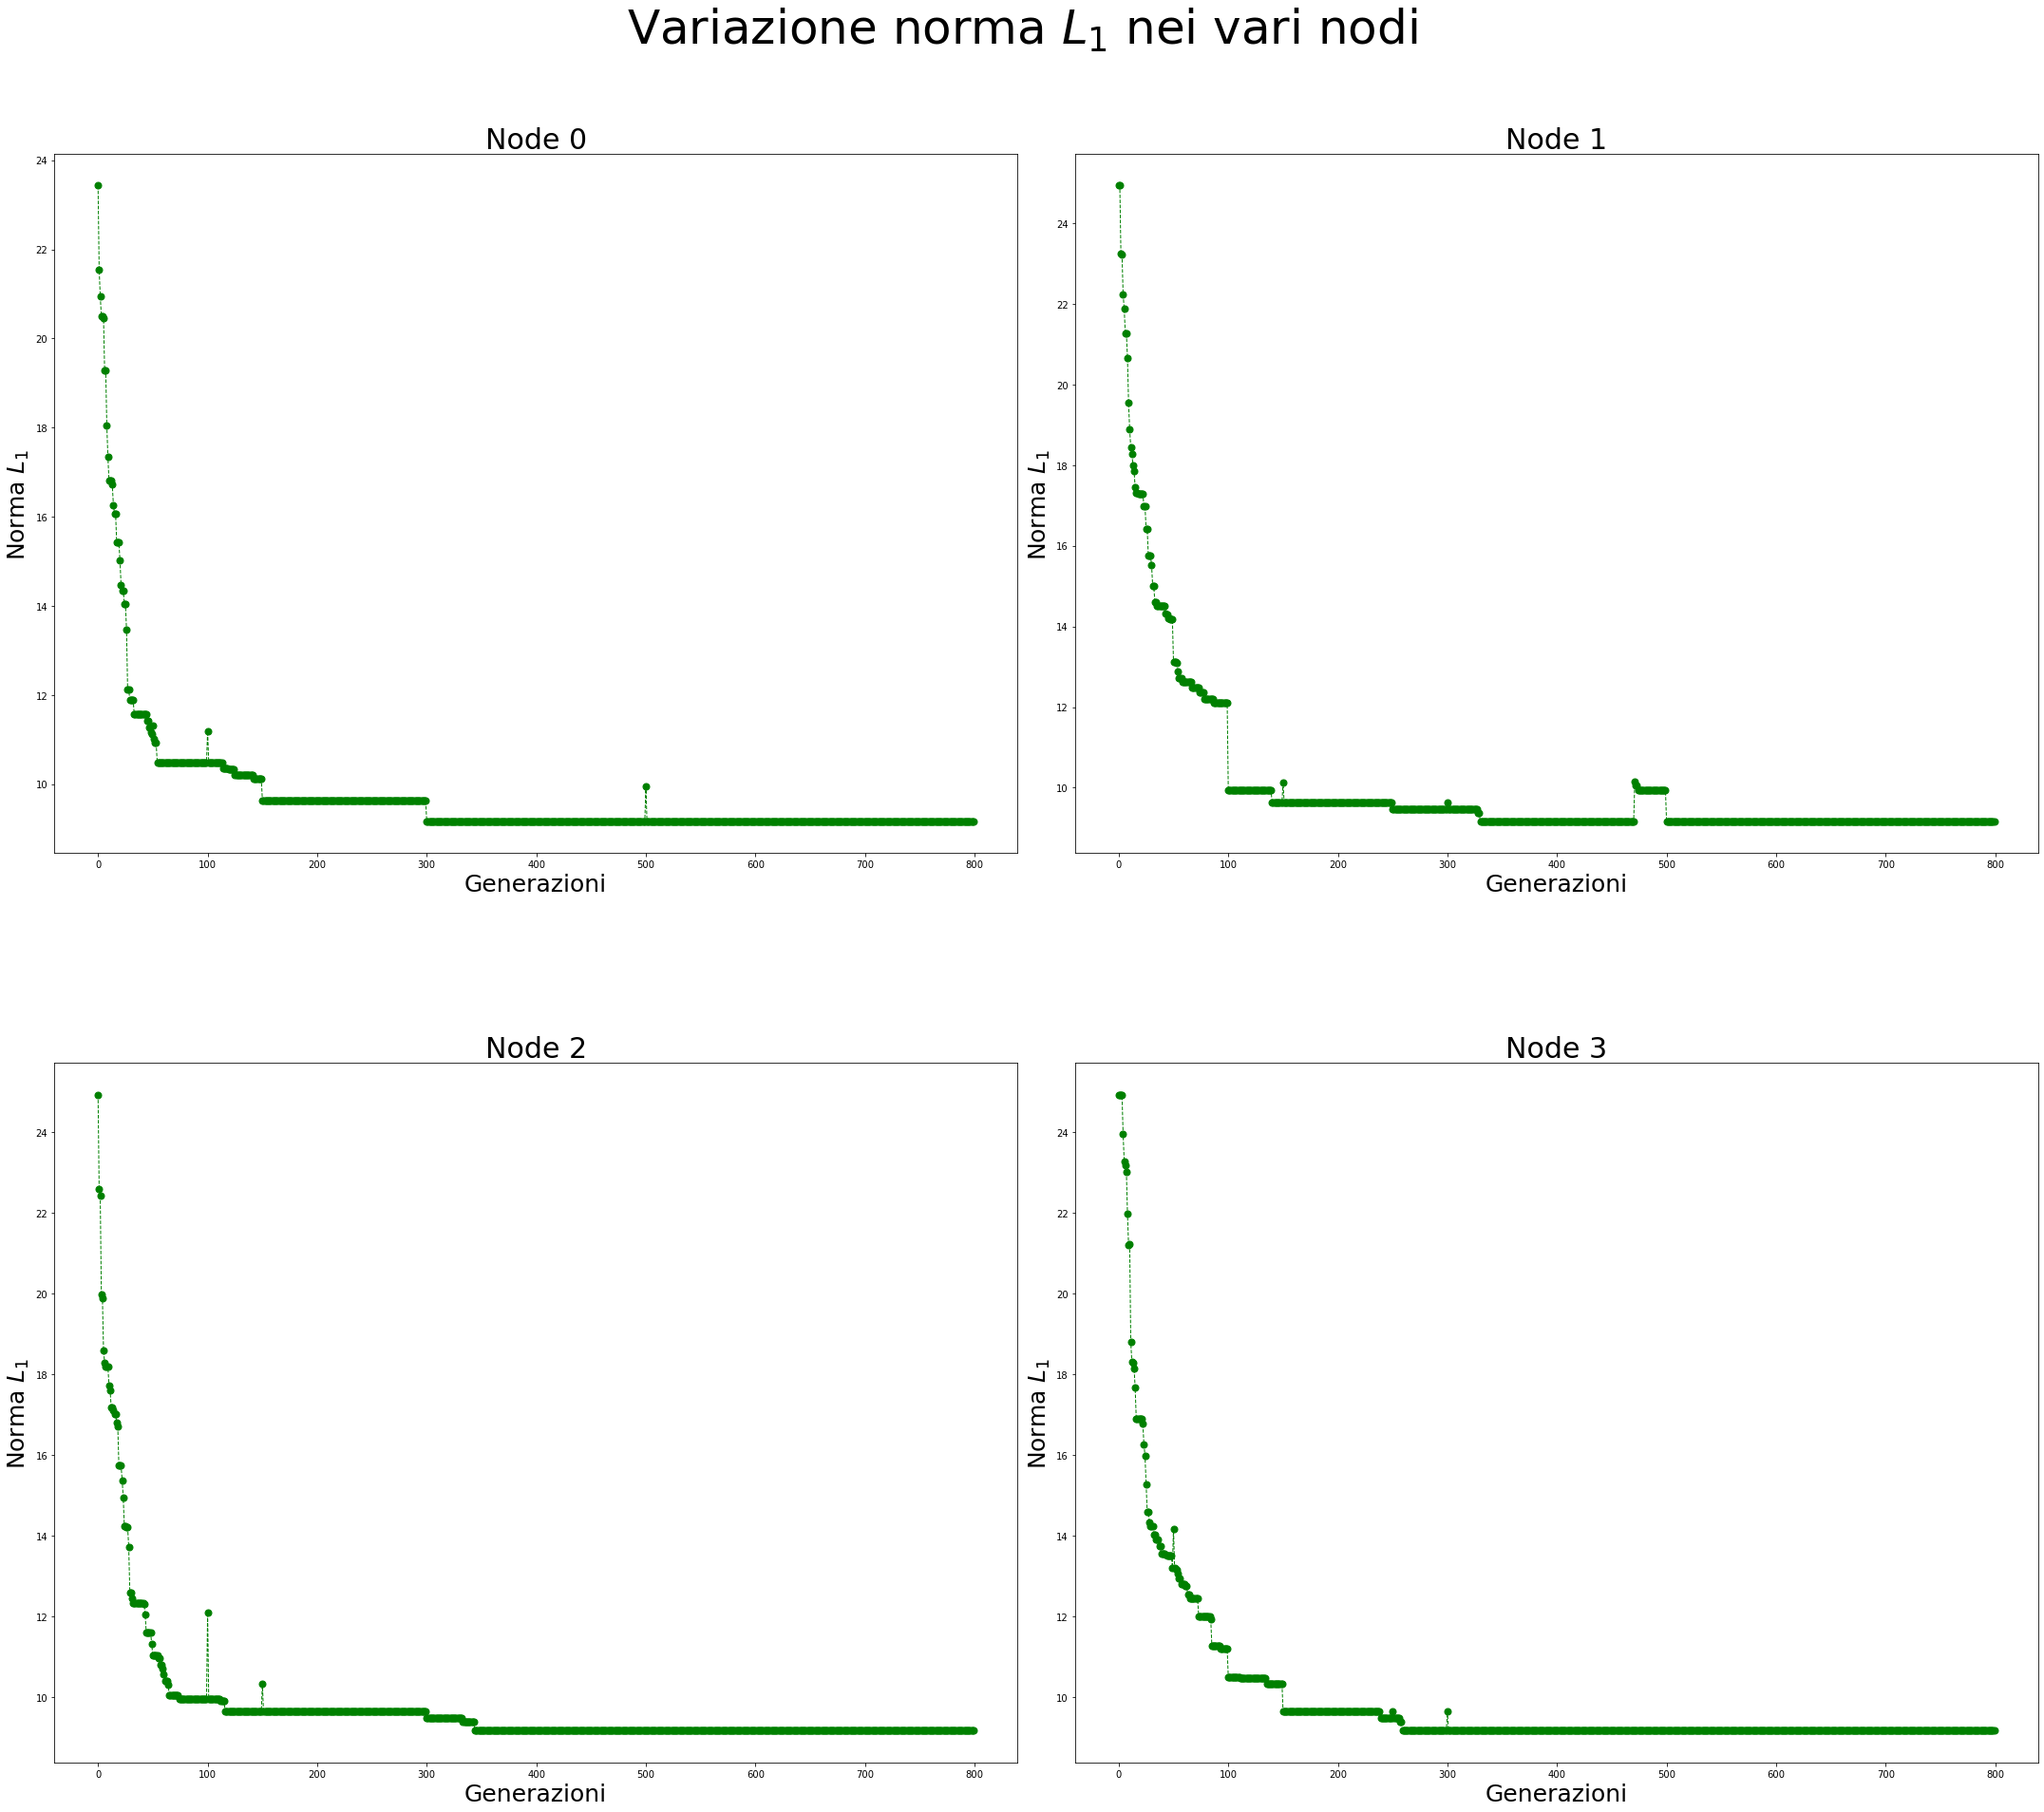

In [9]:
plt.figure(figsize=(30,27))

plt.subplot(2,2,1)
gen, L1 = np.loadtxt("10.2/L_node0.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "g", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("Norma $L_1$", fontsize = 25)
plt.title("Node 0", fontsize = 30)

plt.subplot(2,2,2)
gen, L1 = np.loadtxt("10.2/L_node1.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "g", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("Norma $L_1$", fontsize = 25)
plt.title("Node 1", fontsize = 30)

plt.subplot(2,2,3)
gen, L1 = np.loadtxt("10.2/L_node2.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "g", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("Norma $L_1$", fontsize = 25)
plt.title("Node 2", fontsize = 30)

plt.subplot(2,2,4)
gen, L1 = np.loadtxt("10.2/L_node3.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "g", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("Norma $L_1$", fontsize = 25)
plt.title("Node 3", fontsize = 30)

plt.suptitle("Variazione norma $L_1$ nei vari nodi", fontsize = 50)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()

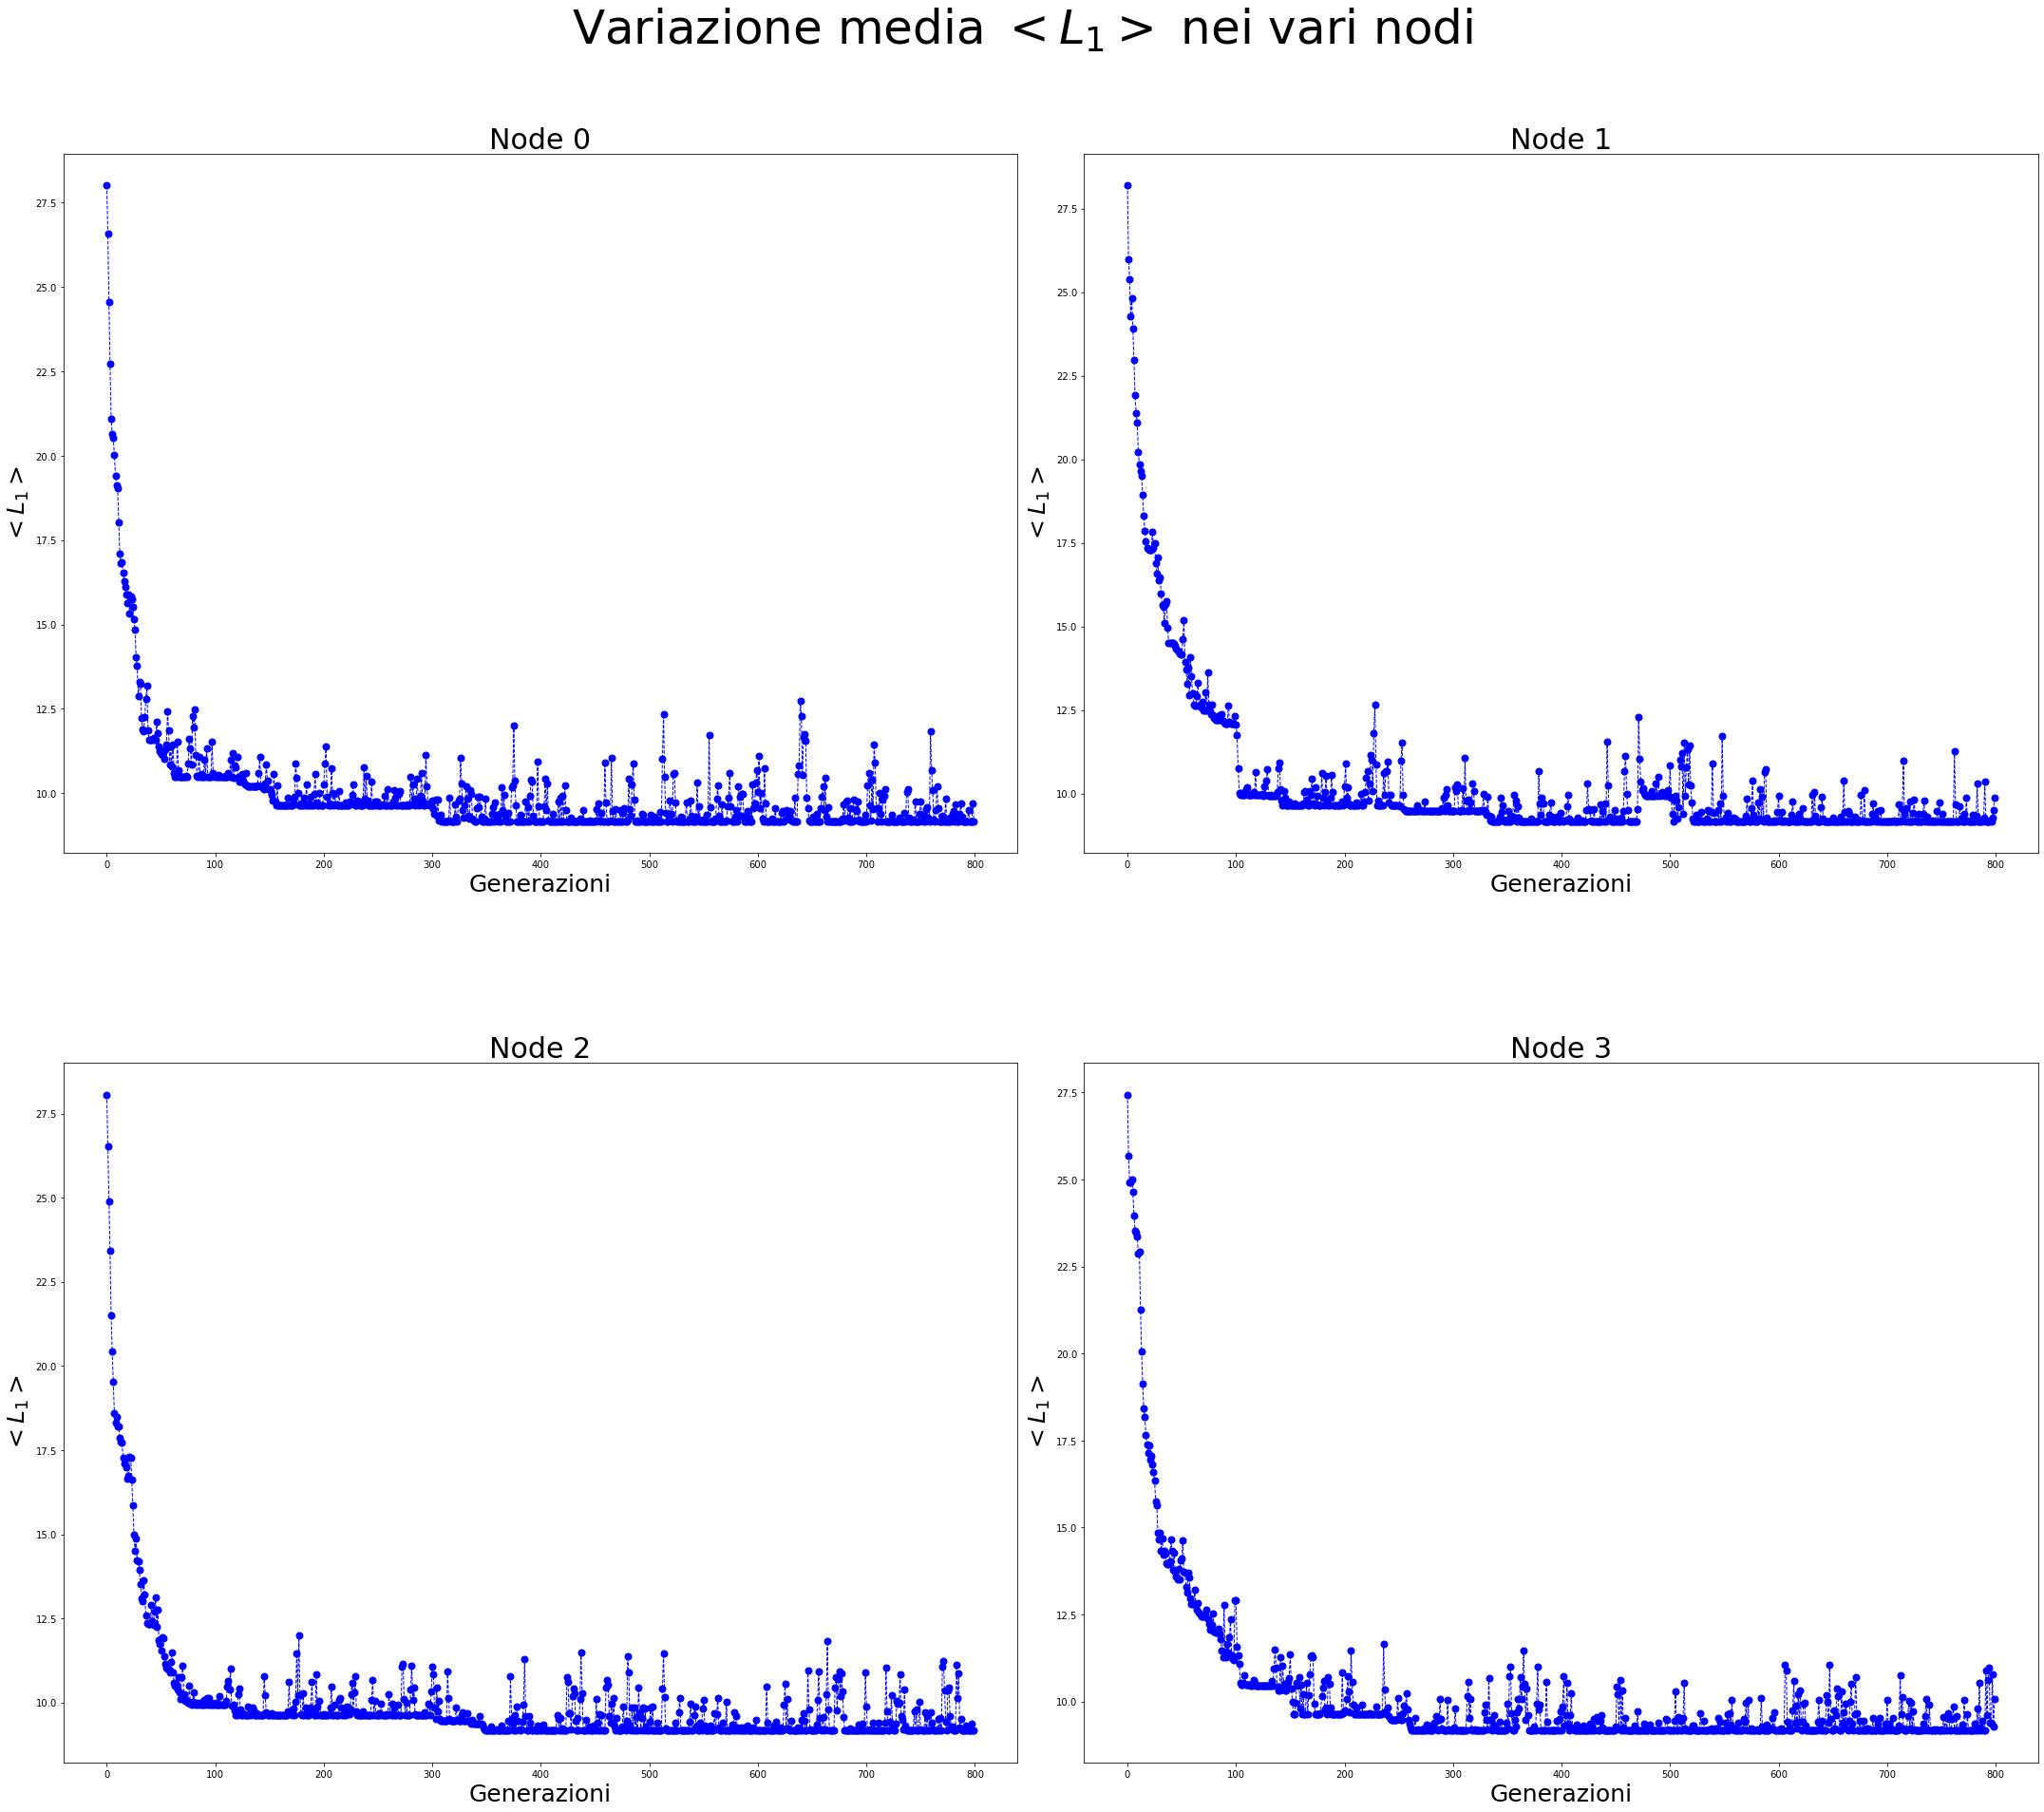

In [11]:
plt.figure(figsize=(30,27))

plt.subplot(2,2,1)
gen, L1 = np.loadtxt("10.2/meanL_node0.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "b", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("$<L_1>$", fontsize = 25)
plt.title("Node 0", fontsize = 30)

plt.subplot(2,2,2)
gen, L1 = np.loadtxt("10.2/meanL_node1.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "b", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("$<L_1>$", fontsize = 25)
plt.title("Node 1", fontsize = 30)

plt.subplot(2,2,3)
gen, L1 = np.loadtxt("10.2/meanL_node2.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "b", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("$<L_1>$", fontsize = 25)
plt.title("Node 2", fontsize = 30)

plt.subplot(2,2,4)
gen, L1 = np.loadtxt("10.2/meanL_node3.dat", usecols = (0, 1), unpack = True)
plt.plot(gen, L1, 'o--', color = "b", markersize = 7., linewidth = 1.)

plt.xlabel("Generazioni", fontsize = 25)
plt.ylabel("$<L_1>$", fontsize = 25)
plt.title("Node 3", fontsize = 30)

plt.suptitle("Variazione media $<L_1>$ nei vari nodi", fontsize = 50)
plt.tight_layout()
plt.subplots_adjust(top=0.9,hspace=0.3)
plt.show()

#### Considerazioni

Nella simulazione viene trovato un valore di minimo locale pari $d = 9,16457$. Come nel caso di algoritmo genetico, anche con un parallel genetic search non si riesce a trovare sempre un valore di minimo globale, in quanto il valore di minimo trovato varia al variare della simulazione la quale può restare bloccata in un minimo locale. Tuttavia un punto di forza di questo metodo è il tempo di simulazione, in quanto sono sufficienti circa $7$ s per simulare $800$ generazioni; sarebbe dunque possibile anche aumentare il numero di generazioni simulate per ricercare il minimo globale, dato il breve tempo di simulazione.